In [1]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy as np 
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL
import freud
import matplotlib.pyplot as plt 

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    vertices = [
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Polygon(
        scene, vertices = vertices, N=len(snapshot.particles.position)
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([100 / 255, 216 / 255, 230 / 255]), roughness=0.2
    )
    positions = np.array(snapshot.particles.position)[:, :2]
    geometry.position[:] = positions

    orientations = np.array(snapshot.particles.orientation)
    angles = 2 * np.arctan2(orientations[:, 3], orientations[:, 0])
    geometry.angle[:] = angles
    
    geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, 0.1, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, 10), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
m = 5
N_particles = m**2
spacing = 1
K = math.ceil(N_particles ** (1 / 2))
L = K * spacing 
x = np.linspace(-L / 2, L / 2, K, endpoint=False)
position = [(px, py, 0) for px, py in itertools.product(x, x)][:N_particles]
orientation = [(1, 0, 0, 0)] * N_particles

# Create GSD snapshot
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position
frame.particles.orientation = orientation
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, 0, 0, 0, 0]
frame.particles.types = ['Hat_Tile']


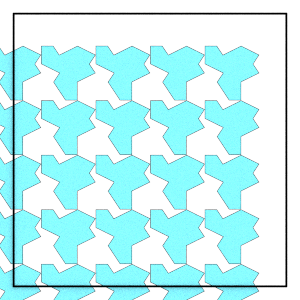

In [4]:
render(frame)

In [5]:
fn = os.path.join(os.getcwd(), '25_tile_lattice.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='25_tile_lattice.gsd', mode='x') as f:
    f.append(frame)

In [6]:
def area():
    vertices = [
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
    n = len(vertices)
    area = 0.5 * abs(sum(vertices[i][0] * vertices[(i + 1) % n][1] - vertices[i][1] * vertices[(i + 1) % n][0] for i in range(n)))
    return area

area = area()
area

0.592948717948718

In [7]:
cpu = hoomd.device.CPU()

In [40]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='25_tile_lattice.gsd')

In [41]:
fn = os.path.join(os.getcwd(), 'trajectory_exp.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_exp.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [42]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.592948717948718, 25.0)

In [43]:
betaP = 0.1
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

volume_fractions = []
pressures = []
timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()
    


Pressure = 0.1, Volume Fraction = 0.592948717948718
Pressure 0.1: Overlaps = 0, Volume Fraction = 0.051761502636781496


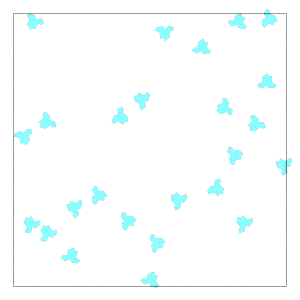

In [21]:
render(simulation.state.get_snapshot())

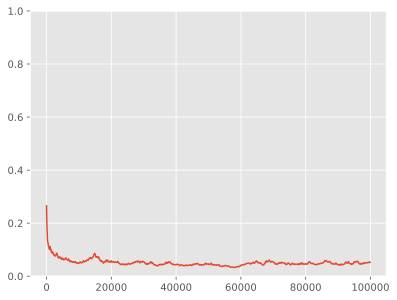

In [44]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions)

In [45]:
vf_plt = []
betaP_plt = []

vf = np.mean(volume_fractions[len(volume_fractions)//2:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

np.float64(0.0467925521900582)

In [46]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_exp.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp1.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp1.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [47]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.05176150797276269, 286.3849707879126)

In [48]:
betaP = 1
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()
    


Pressure = 1, Volume Fraction = 0.05176150797276269
Pressure 1: Overlaps = 0, Volume Fraction = 0.2581975577098956


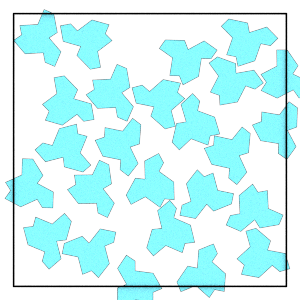

In [99]:
render(simulation.state.get_snapshot())

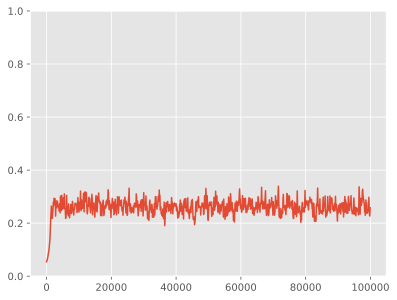

In [54]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

In [58]:
vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

np.float64(0.2623216387746611)

In [59]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp1.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp2.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp2.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [60]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.2581975470091342, 57.4123113113601)

In [61]:
betaP = 2
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()


Pressure = 2, Volume Fraction = 0.2581975470091342
Pressure 2: Overlaps = 0, Volume Fraction = 0.3455967223050199


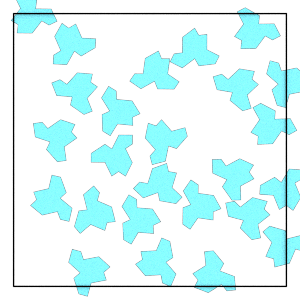

In [62]:
render(simulation.state.get_snapshot())

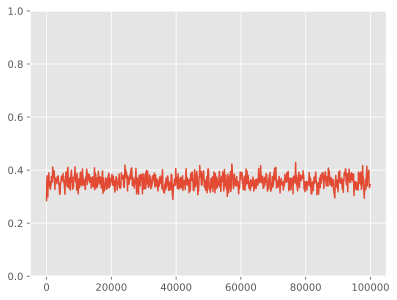

In [63]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

In [65]:
vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

np.float64(0.35728384660473095)

In [66]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp2.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp3.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp3.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [67]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.34559673054716455, 42.89310817625028)

In [68]:
betaP = 3
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()


Pressure = 3, Volume Fraction = 0.34559673054716455
Pressure 3: Overlaps = 0, Volume Fraction = 0.4525281920059233


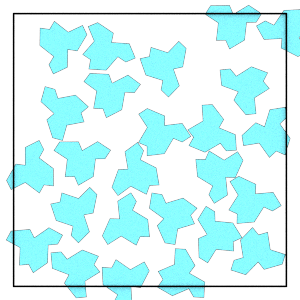

In [69]:
render(simulation.state.get_snapshot())

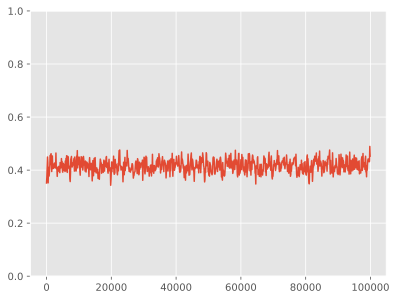

In [70]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

In [72]:
vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

np.float64(0.41702139046840964)

In [73]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp3.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp4.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp4.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [74]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.45252822350874133, 32.757554509595366)

In [75]:
betaP = 4
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()


Pressure = 4, Volume Fraction = 0.45252822350874133
Pressure 4: Overlaps = 0, Volume Fraction = 0.45785993383848145


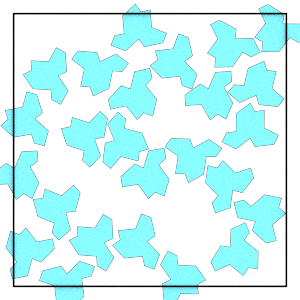

In [76]:
render(simulation.state.get_snapshot())

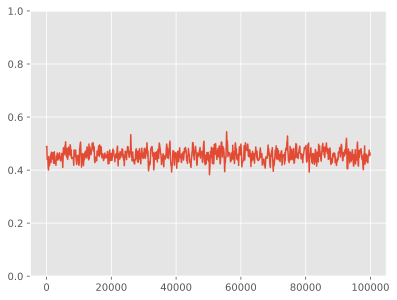

In [77]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

In [78]:
vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

np.float64(0.4569335507500033)

In [85]:
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='trajectory_cmp4.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp5.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp5.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [86]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.45785996877660395, 32.37609522476214)

In [87]:
betaP = 5
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps = []

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()


Pressure = 5, Volume Fraction = 0.45785996877660395
Pressure 5: Overlaps = 0, Volume Fraction = 0.4509956287332295


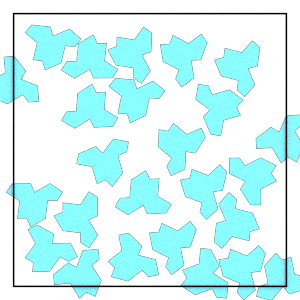

In [88]:
render(simulation.state.get_snapshot())

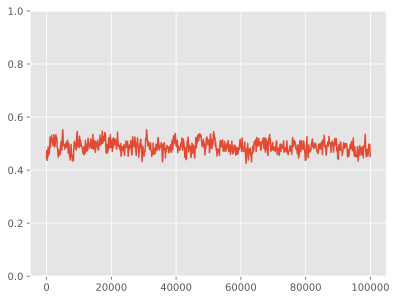

In [89]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

In [90]:
vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

np.float64(0.4855624897920859)

In [91]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp5.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp6.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp6.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [92]:
vf = simulation.state.N_particles * area / simulation.state.box.volume
vf, simulation.state.box.volume

(0.45099563549687305, 32.86887229493095)

In [93]:
betaP = 6
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()


Pressure = 6, Volume Fraction = 0.45099563549687305
Pressure 6: Overlaps = 0, Volume Fraction = 0.4587084459265725


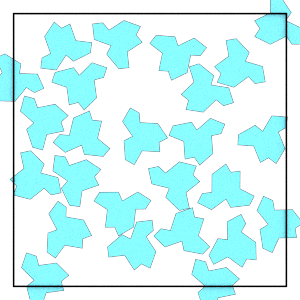

In [94]:
render(simulation.state.get_snapshot())

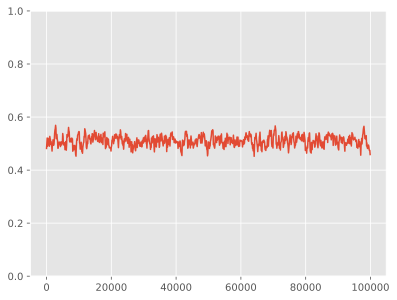

In [95]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

In [96]:
vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

np.float64(0.5102774498173048)

In [97]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp6.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp7.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp7.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [98]:
betaP = 7
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 7, Volume Fraction = 0.45870843003838135
Pressure 7: Overlaps = 0, Volume Fraction = 0.527516829508645


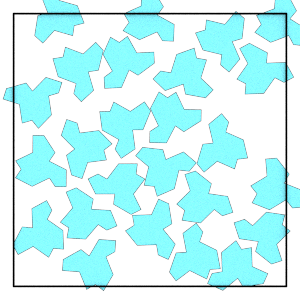

In [99]:
render(simulation.state.get_snapshot())

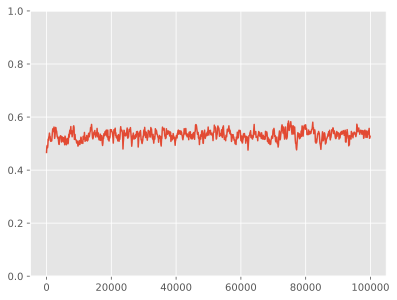

In [100]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

In [101]:
vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

np.float64(0.5339765623353746)

In [106]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp7.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp8.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp8.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [107]:
betaP = 8
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 8, Volume Fraction = 0.5275168768268714
Pressure 8: Overlaps = 0, Volume Fraction = 0.571522336691737


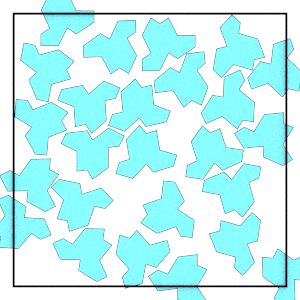

In [108]:
render(simulation.state.get_snapshot())

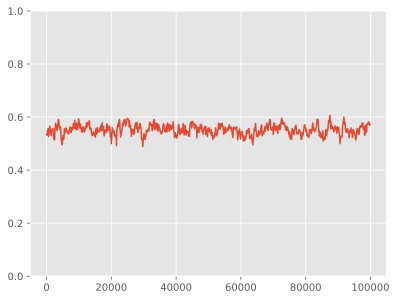

In [109]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

In [110]:
vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

np.float64(0.5495480304674487)

In [115]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp8.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp9.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp9.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [116]:
betaP = 9
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 9, Volume Fraction = 0.5715223557128188
Pressure 9: Overlaps = 0, Volume Fraction = 0.5469992491650341


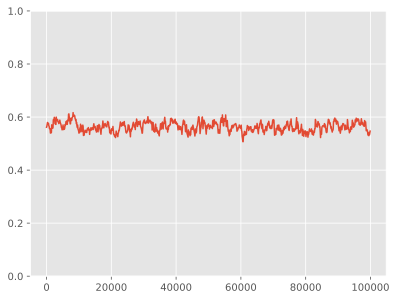

In [117]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

In [118]:
vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

np.float64(0.5612945326643196)

In [122]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp9.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp10.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp10.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 10
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 10, Volume Fraction = 0.5469992242877356
Pressure 10: Overlaps = 0, Volume Fraction = 0.580427433426772


np.float64(0.576934924815051)

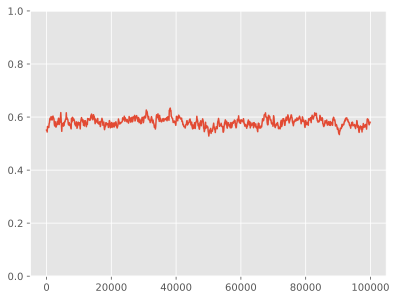

In [123]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

In [124]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp10.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp11.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp11.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 11
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 11, Volume Fraction = 0.5804273972723182
Pressure 11: Overlaps = 0, Volume Fraction = 0.6002325203071729


np.float64(0.585541246164746)

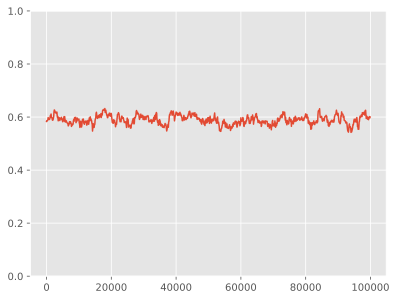

In [125]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

In [126]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp11.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp12.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp12.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 12
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 12, Volume Fraction = 0.6002324772533155
Pressure 12: Overlaps = 0, Volume Fraction = 0.5890412676691889


np.float64(0.6015498733776067)

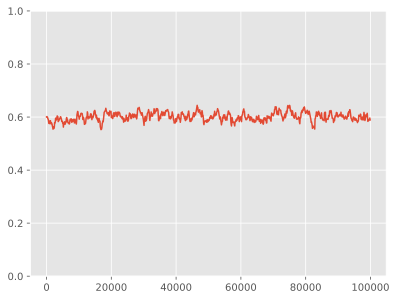

In [127]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

In [128]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp12.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp13.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp13.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 13
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 13, Volume Fraction = 0.5890412182225307
Pressure 13: Overlaps = 0, Volume Fraction = 0.6207747739743463


np.float64(0.6095275130976658)

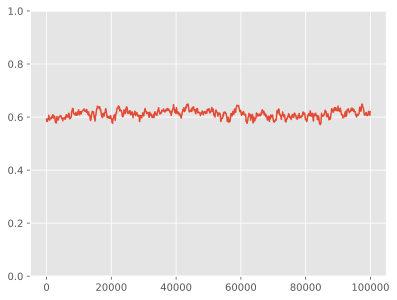

In [129]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

In [130]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp13.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp14.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp14.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 14
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 14, Volume Fraction = 0.6207747816778075
Pressure 14: Overlaps = 0, Volume Fraction = 0.6437894994831571


np.float64(0.6179396374133985)

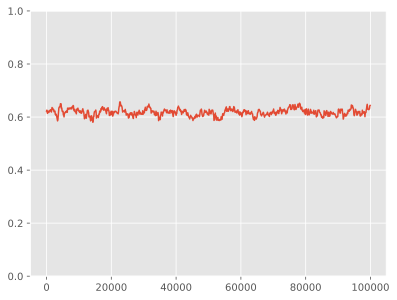

In [131]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

In [133]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp14.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp15.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp15.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 15
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 15, Volume Fraction = 0.6437895005575485
Pressure 15: Overlaps = 0, Volume Fraction = 0.6225655711738545


np.float64(0.633949303459708)

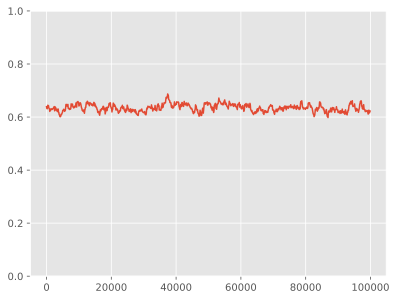

In [134]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

In [135]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp15.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp16.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp16.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 16
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 16, Volume Fraction = 0.6225656062334236
Pressure 16: Overlaps = 0, Volume Fraction = 0.6297986385212538


np.float64(0.6388731506637927)

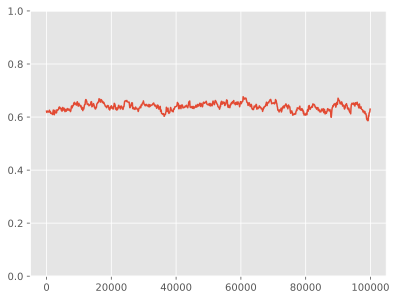

In [136]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

In [137]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp16.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp17.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp17.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 17
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 17, Volume Fraction = 0.6297986654533474
Pressure 17: Overlaps = 0, Volume Fraction = 0.6450405596014462


np.float64(0.6467155118738089)

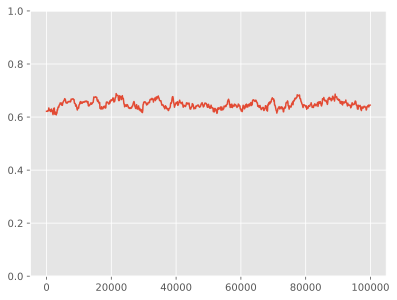

In [138]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

In [139]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp17.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp18.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp18.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 18
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 18, Volume Fraction = 0.6450406164784184
Pressure 18: Overlaps = 0, Volume Fraction = 0.6602380327034885


np.float64(0.6562872043523716)

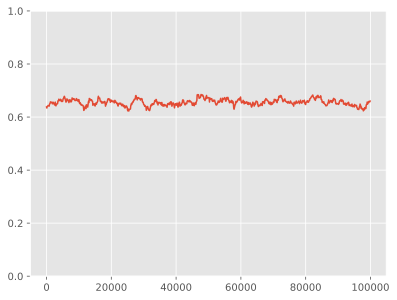

In [140]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

In [141]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp18.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp19.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp19.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 19
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 19, Volume Fraction = 0.6602380126909544
Pressure 19: Overlaps = 0, Volume Fraction = 0.6764568395551073


np.float64(0.661864926200128)

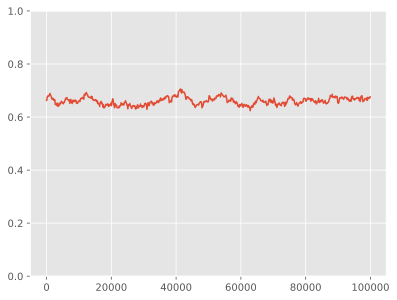

In [142]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

In [143]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp19.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp20.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp20.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 20
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

Pressure = 20, Volume Fraction = 0.676456837576225
Pressure 20: Overlaps = 0, Volume Fraction = 0.6694389621148198


np.float64(0.6750993159222276)

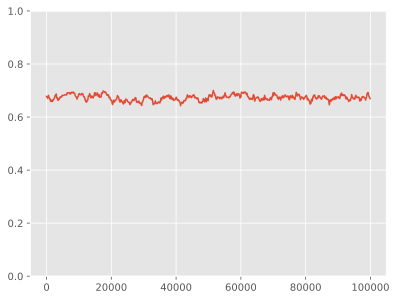

In [144]:
plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

Pressure = 21, Volume Fraction = 0.6694389438749135
Pressure 21: Overlaps = 0, Volume Fraction = 0.6563454298421597


np.float64(0.6729600885933381)

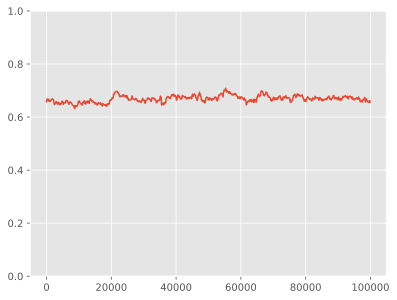

In [146]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp20.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp21.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp21.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 21
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

Pressure = 22, Volume Fraction = 0.6563454671451178
Pressure 22: Overlaps = 0, Volume Fraction = 0.6870066004882865


np.float64(0.6762750506138374)

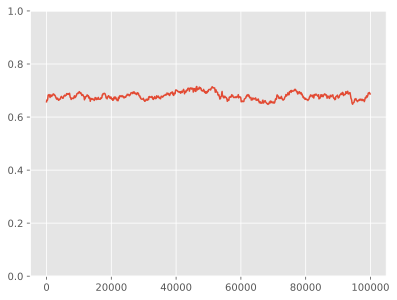

In [147]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp21.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp22.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp22.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 22
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

Pressure = 23, Volume Fraction = 0.6870066204113587
Pressure 23: Overlaps = 0, Volume Fraction = 0.6982599883816368


np.float64(0.6858812532644836)

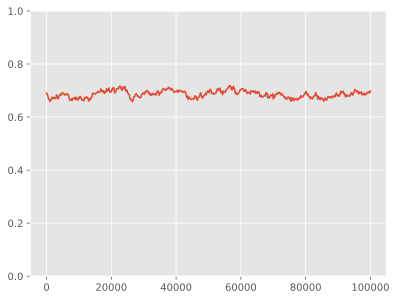

In [149]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp22.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp23.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp23.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 23
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

Pressure = 24, Volume Fraction = 0.6982600289772045
Pressure 24: Overlaps = 0, Volume Fraction = 0.6678687290593134


np.float64(0.69201255332997)

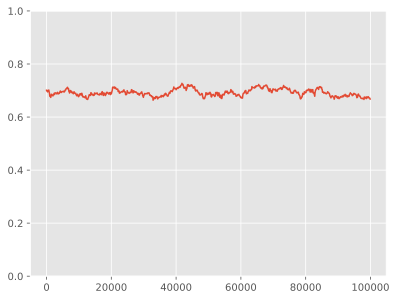

In [150]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp23.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp24.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp24.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 24
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

Pressure = 25, Volume Fraction = 0.667868738524876
Pressure 25: Overlaps = 0, Volume Fraction = 0.7257522497968111


np.float64(0.6985768809882144)

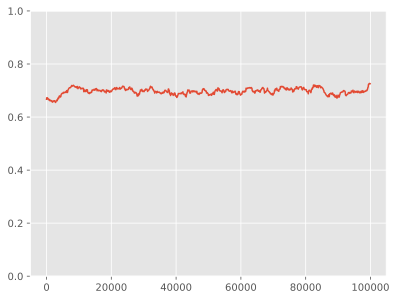

In [151]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_cmp24.gsd')

fn = os.path.join(os.getcwd(), 'trajectory_cmp25.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_cmp25.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

betaP = 25
weight = 1
delta = 1.5
run_steps = 10_0000
log_interval = 100

mc = hoomd.hpmc.integrate.SimplePolygon()
mc.shape['Hat_Tile'] = dict(
    vertices=[
        (0.1709401709401709,-0.5899408284023668),
        (0.1709401709401709,-0.2553254437869822),
        (0.5042735042735043,-0.08994082840236695),
        (0.3931623931623931,0.07544378698224852),
        (0.5042735042735043,0.2446745562130177),
        (0.1709401709401709,0.41005917159763317),
        (-0.16239316239316243,0.2446745562130177),
        (-0.27350427350427353,0.41005917159763317),
        (-0.49572649572649574,0.41005917159763317),
        (-0.49572649572649574,0.07544378698224852),
        (-0.16239316239316243,-0.08994082840236695),
        (-0.27350427350427353,-0.2553254437869822),
        (-0.05128205128205132,-0.5899408284023668)
    ]
)
simulation.operations.integrator = mc

boxmc = hoomd.hpmc.update.BoxMC(
    trigger=hoomd.trigger.Periodic(1),
    betaP=betaP
)

boxmc.volume = dict(
    mode='standard',
    weight=weight,
    delta=delta
)
  
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.6,
    max_translation_move=2,
    max_rotation_move=0.8
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.3,
    max_move_size={'volume':10}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

timesteps =[]

vf = (simulation.state.N_particles * area) / simulation.state.box.volume
print(f"Pressure = {betaP}, Volume Fraction = {vf}")

for step in range(0, run_steps, log_interval):
    simulation.run(log_interval)
    
    current_vf = (simulation.state.N_particles * area) / simulation.state.box.volume
    timesteps.append(step)
    volume_fractions.append(current_vf)
    pressures.append(betaP)
    
print(f"Pressure {betaP}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

gsd_writer.flush()

plt.ylim(0,1)
plt.plot(timesteps, volume_fractions[-1000:])

vf = np.mean(volume_fractions[-500:])
vf_plt.append(vf)
betaP_plt.append(betaP)

vf

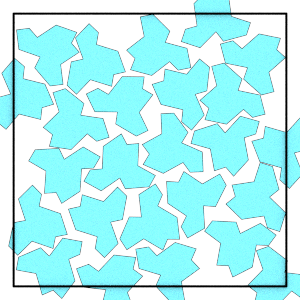

In [157]:
render(simulation.state.get_snapshot())

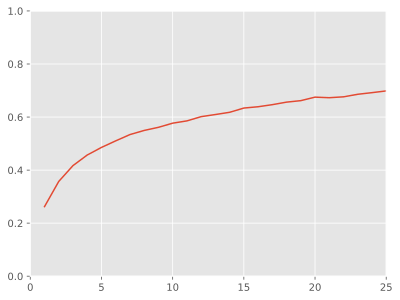

In [155]:
plt.ylim(0,1)
plt.xlim(0,25)
plt.plot(betaP_plt, vf_plt)

In [156]:
data = np.column_stack((pressures, volume_fractions))
np.savetxt('log.csv', data, delimiter=',', header='betaP, Volume Fraction', comments='')